# A* Search

We will be trying to find and visualize the path between Equestrian Statue of Edward VII and Bahen Center of Technology around Toronto University campus using A* search

**PQ** &larr; min heap according to **A-star heuristic**  
**A-star heuristic** &larr; sum of distance between node to _goal_ and node to _destination_  


__A*-SEARCH__ ( _source_ , _destination_ ) __return__ a route     
&emsp;_frontier_ &larr; a **PQ** initialized with _source_ node  
&emsp;_explored_ &larr; empty    
&emsp;_found_ &larr; False    
&emsp;__while__  _frontier_ **is not** empty **and** _found_ **is** _False_  __do__    
&emsp;&emsp;&emsp;_node_ &larr; _frontier_.pop()    
&emsp;&emsp;&emsp;**add** _node_ **to** _explored_  
&emsp;&emsp;&emsp;__for__ _child_ __in__ _node_.expand() __do__   
&emsp;&emsp;&emsp;&emsp;&emsp;__if__ _child_ __is not in__ _explored_ __and__ _child_ __is not in__ _frontier_   __then__  
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; __if__ _child_ __is__ _destination_ __then__  
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; _route_ &larr; _child_.route()  
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; _found_ &larr; _True_  
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;__add__ _child_ __to__ _frontier_    
&emsp;__return__  _route_

In [ ]:
%%capture

##############################################################################
# IGNORE if you are running on a local machine and have all the dependencies #
##############################################################################

# installing dependencies --- to be able to run on google colab
# it would take 2-3 minutes
!apt-get install libspatialindex-c4v5;
!pip3 install Rtree;
!pip3 install osmnx;
!pip3 install tqdm;
!pip3 install ipyleaflet;

# You need to upload Utilities.zip in /content directory which is the default
!unzip Utilities.zip

In [1]:
import osmnx as ox
import time
from collections import deque
from tqdm import tqdm
from Utilities.utils import *

Here OSMnx returns the largest connected component centered around the ```location point``` with specified ```dist``` on each side (w/n/e/s).

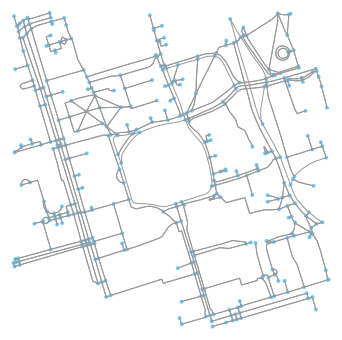

In [2]:
location_point = (43.661667, -79.395)
G = ox.graph_from_point(location_point, dist=300, clean_periphery=True, simplify=True)
graph_map = ox.plot_graph_folium(G, popup_attribute='name', edge_width=2)
fig, ax = ox.plot_graph(G)

Here you need to specify which node from our graph is the source (Equestrian Statue of Edward VII) and which is the destination node (Bahen Center of Technology). You can do so by acquiring the decimal coordinates of the desired node and use [```osmnx.distance.get_nearest_node```](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.distance.get_nearest_node) method

I used the aforementioned method and found that the nodes for destination and source are 389677909, 55808290 respectively

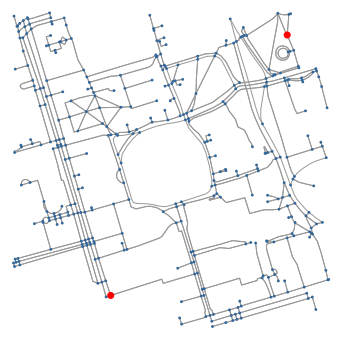

In [3]:
highlighted = [389677909, 55808290]

# marking both the source and destination node

nc = ['r' if node in highlighted else '#336699' for node in G.nodes()]
ns = [50 if node in highlighted else 8 for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_size=ns, node_color=nc, node_zorder=2)

In [4]:
draw_map(G, highlight = highlighted)

Map(center=[43.6618621, -79.3941032], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_titl…

Each node in our graph is represented as a dictionary so manipulating them would obfuscate the algorithm manipulating them and would be unnecessary expensive computationally <b>so</b> we define class ```Node``` only retains the data we need to be able to do searching and traversing.

Please check its source code in ```./Utilities/utils/oxm.py``` to know how it capture the data from the graph

In [5]:
%%capture
source(Node)

# The Algorithm

In [6]:
# first define the origin/source nodes as Node
origin = Node(graph = G, osmid = 55808290)
destination = Node(graph = G, osmid = 389677909)

## The Heuristic

What drives node expansion in A* algorithm is determining the closet node to both the origin and destination by summing these both distances so what we need here is a function that returns a data structure that associates with each node that metric

In [7]:
source(astar_heuristic)

In [8]:
toGoal, toDestination = astar_heuristic(G, 55808290, 389677909)

Now we need to have a kind of priority queue like we did in ```dijkstra``` algorithm but we can't relay on Python standard libraries here because ```toGoal``` and ```toDestination``` metrics are not from ```Node``` attributes

What we will do here is have a typical minimum heap for our nodes with a lambda function define the heapify-ing metric which is the summation of the ```toDestination``` and ```toGoal``` distances  
  
All of that could be accomplished with python list and lambda functions

In [9]:
%%time
frontier = list()

route = []
bar = tqdm(total=len(G)) # for the progress bar

frontier.append(origin)
explored = set()
found = False

while frontier and not found:
    bar.update(1); time.sleep(0.05)
    
    # choose a node based on its heuristic value
    node = min(frontier, key = lambda node : toGoal[node.osmid] + toDestination[node.osmid])
    frontier.remove(node)
    explored.add(node)
    
    # expand its children
    for child in node.expand():
        if child not in explored and child not in frontier:
            if child == destination:
                route = child.path()
                found = True
                continue
            frontier.append(child)

bar.close()
print("The route is \n\n",route, "\n\nits cost is\n\n", cost(G, route))

 24%|██▍       | 92/379 [00:09<00:29,  9.77it/s]

The route is 

 [55808290, 304891685, 55808284, 1252869817, 55808239, 389678268, 4953810915, 389678267, 24960090, 389678273, 1258698113, 389678151, 389678142, 2143489694, 389678141, 2143488528, 389678140, 389678139, 389678138, 3707407638, 6028561924, 6028561921, 389678131, 6028562356, 854322047, 389677908, 749952029, 389677909] 

its cost is

 838.9339999999999
CPU times: user 272 ms, sys: 40.6 ms, total: 313 ms
Wall time: 9.42 s


let's visualize that route

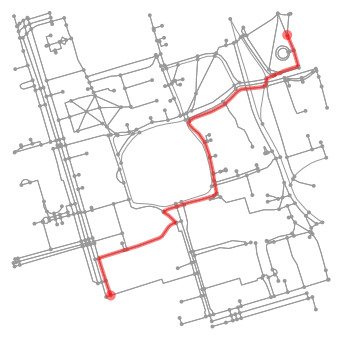

In [10]:
fig, ax = ox.plot_graph_route(G, route)

In [11]:
draw_route(G, route)

Map(center=[43.6618621, -79.3941032], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_titl…